## This code is to read from the corpus of lines that have English and Spanish lines
(Source: http://www.manythings.org/anki/ spa-eng.zip)

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import re
import string

# Visualization library
import seaborn as sns
import matplotlib.pyplot as plt

# NLP library
from nltk.tokenize import word_tokenize


In [2]:
#Ensuring same seed for future replication
from numpy.random import seed
seed(42)

In [3]:
#Reading lines from the Spanish - English text file
lines= pd.read_table('spa.txt', names=['eng', 'spa'])

In [4]:
#Looking at sample lines
lines.head()

,eng,spa
Go.,Ve.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
Go.,Vete.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
Go.,Vaya.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
Go.,Váyase.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
Hi.,Hola.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


In [5]:
#See how many rows we have
lines.shape

(128084, 2)

In [6]:
#Check for nulls
lines.isnull().sum()

eng    0
spa    0
dtype: int64

## English word seems to have gone into index, column names need to be adjusted

In [7]:
#Remove english word as index into main column and dropping source of the line as a column
lines.reset_index(inplace=True)
lines.columns=['eng', 'spa', 'misc']
lines.drop(columns='misc', inplace=True)

## Data Cleansing so that it can be worked upon later

In [8]:
# Lowercase all characters
lines['eng']=lines['eng'].apply(lambda x: x.lower())
lines['spa']=lines['spa'].apply(lambda x: x.lower())

# Remove quotes, inverted question marks from Spanish
lines['eng']=lines['eng'].apply(lambda x: re.sub("'", '', x))
lines['spa']=lines['spa'].apply(lambda x: re.sub("¿", '', x))
lines['spa']=lines['spa'].apply(lambda x: re.sub("'", '', x))

# Remove all the special characters
exclude = set(string.punctuation) # Set of all special characters

lines['eng']=lines['eng'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines['spa']=lines['spa'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

# Remove all numbers from text
remove_digits = str.maketrans('', '', string.digits)
lines['eng']=lines['eng'].apply(lambda x: x.translate(remove_digits))
lines['spa']=lines['spa'].apply(lambda x: x.translate(remove_digits))

# Remove extra spaces
lines['eng']=lines['eng'].apply(lambda x: x.strip())
lines['spa']=lines['spa'].apply(lambda x: x.strip())
lines['eng']=lines['eng'].apply(lambda x: re.sub(" +", " ", x))
lines['spa']=lines['spa'].apply(lambda x: re.sub(" +", " ", x))

# Add start and end tokens to target sequences
#lines['spa']=lines['spa'].apply(lambda x : 'START_ '+ x + ' _END')

In [9]:
#Review sample lines from english
lines[['eng', 'spa']][100:110]

,eng,spa
100,no way,¡mangos
101,no way,¡minga
102,no way,¡ni en pedo
103,really,en serio
104,really,la verdad
105,thanks,¡gracias
106,thanks,gracias
107,try it,pruébalo
108,we ate,comimos
109,we try,lo procuramos


In [10]:
# Moving into df dataframe and doing some EDA
df = lines[['eng', 'spa']]

# Calculating the length of each line of dialogue
df['eng_len'] = df['eng'].apply(lambda x: len(x))
df['spa_len'] = df['spa'].apply(lambda x: len(x))

## Let's find duplicate English words and remove them from the corpus.  This is because we have to later limit how many lines can be used to build the corpus.  So even though same English words may have different Spanish words and meanings, we can get more distinct words in our corpus.

In [11]:
# Find duplicate rows for sentences in English
duplicateEngRow = df[df.duplicated(['eng'])]
print(duplicateEngRow.shape)

(19226, 4)


## There are about 19k duplicate English lines, let us remove these from the overall 128k lines in the text file

In [12]:
#Creating deduped dataframe dropping English duplicates to create dfd (df-deduped)
#Source https://stackoverflow.com/questions/44546086/remove-one-dataframe-from-another-with-pandas
dfd = pd.merge(df, duplicateEngRow, how='outer', indicator=True).query("_merge != 'both'").drop('_merge', axis=1).reset_index(drop=True)

In [13]:
#Checking shape - confirms that we dropped ~19k rows
dfd.shape

(108796, 4)

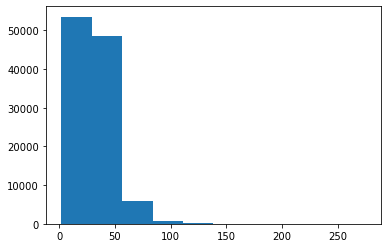

In [14]:
#Checking histogram of character count in Spanish
plt.hist(dfd['spa_len']);

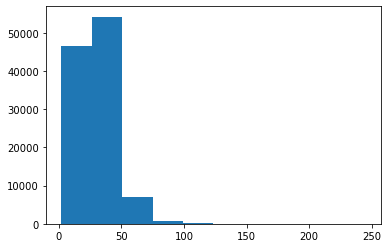

In [15]:
#Checking histogram of English character counts
plt.hist(dfd['eng_len']);

## There are a lot of tails, clipping off at 50 character count at high end will help to keep vectors manageable for each line

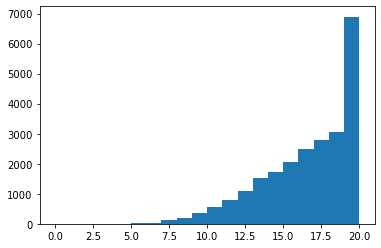

In [16]:
#Checking histogram of English character counts at lower end
plt.hist(dfd['eng_len'], range(0, 21));

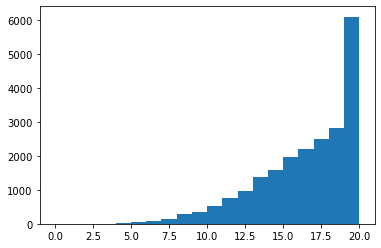

In [17]:
#Checking histogram of English character counts at lower end
plt.hist(dfd['spa_len'], range(0, 21));

In [18]:
# Saving dataframe with dialogue length less than 50 characters and more than 18 characters from the EDA above
dfd = dfd[dfd['eng_len']< 50]
dfd = dfd[dfd['eng_len']> 18]
dfd = dfd[dfd['spa_len']> 15]
dfd = dfd[dfd['spa_len']< 58]

data = dfd.values.tolist()

# Examining the first 5 rows
data[:5]

[['a dog has four legs', 'un perro tiene cuatro patas', 19, 27],
 ['a lion is an animal', 'un león es un animal', 19, 20],
 ['a noise woke her up', 'un ruido la despertó', 19, 20],
 ['a nurse wears white', 'una enfermera se viste de blanco', 19, 32],
 ['a truck hit the dog', 'un camión atropelló al perro', 19, 28]]

In [19]:
dfd.head()

,eng,spa,eng_len,spa_len
15828,a dog has four legs,un perro tiene cuatro patas,19,27
15829,a lion is an animal,un león es un animal,19,20
15830,a noise woke her up,un ruido la despertó,19,20
15831,a nurse wears white,una enfermera se viste de blanco,19,32
15832,a truck hit the dog,un camión atropelló al perro,19,28


In [20]:
# Clipping for shorter and longer lines, we are at 83k lines
len(data)

80612

In [22]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [23]:
# vectorizing text with 1,2 ngrams and 10,000 max features instead of 20,000 from previous notebook
tvec = TfidfVectorizer(ngram_range=(1,2), max_features=10_000)
df_tvec = tvec.fit_transform(df['eng'])




In [29]:

from nltk.corpus import stopwords

scipy.sparse.csr.csr_matrix

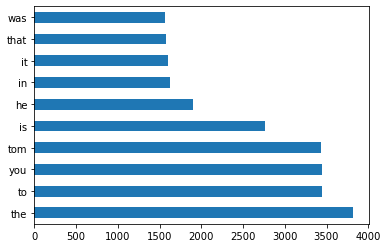

In [26]:
# top-occurring words
df_tvec_df = pd.DataFrame(df_tvec.todense(),
                         columns=tvec.get_feature_names())

df_tvec_df.sum().sort_values(ascending = False).head(10).plot(kind='barh');

In [47]:
#Write to csv so it can be used for continuous training later
dfd.to_csv('./data/EngSpa.csv')